# 🛰️ Sentinel-2 Water Body Segmentation with TransUNet

**Task:** Binary Segmentation (Water vs. Non-Water)  
**Input:** 6-Band Sentinel-2 Imagery (Blue, Green, Red, NIR, SWIR1, SWIR2)  
**Model:** Transformer-UNet Hybrid (TransUNet)  

## 📋 Notebook Overview
1.  **Setup:** Mount Google Drive and install geospatial libraries.
2.  **Data Loading:** Custom PyTorch Dataset for 6-channel `.tif` files.
3.  **Model:** A hybrid architecture using CNN encoders for features and a Transformer bottleneck for global context.
4.  **Training:** Training loop with mixed precision, Dice Loss, and metric tracking.
5.  **Inference:** Visualization of RGB composites, Ground Truth, and Model Predictions.

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Setup & Dependencies
We need `rasterio` for handling geospatial TIFF files and `albumentations` for image augmentation.

In [ ]:

import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from tqdm.notebook import tqdm
import cv2

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Device set to: {device}")

✅ Device set to: cuda


## 2. Configuration & Drive Mount
Mount your Google Drive and define the dataset paths.

In [3]:
from google.colab import drive

# --- CONFIGURATION ---
class Config:
    ROOT_DIR = '/content/drive/MyDrive/dset-s2/'
    TRAIN_IMG_DIR = os.path.join(ROOT_DIR, 'tra_scene')
    TRAIN_MASK_DIR = os.path.join(ROOT_DIR, 'tra_truth')
    VAL_IMG_DIR = os.path.join(ROOT_DIR, 'val_scene')
    VAL_MASK_DIR = os.path.join(ROOT_DIR, 'val_truth')

    SAVE_PATH = '/content/drive/MyDrive/water_transformer_best.pth'

    # Hyperparameters
    IMG_SIZE = 256      # Resize input to this
    IN_CHANNELS = 6     # (B2, B3, B4, B8, B11, B12)
    BATCH_SIZE = 8
    LEARNING_RATE = 1e-4
    EPOCHS = 20
    NUM_WORKERS = 2

# Mount Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Drive already mounted.")

# Basic Check
if os.path.exists(Config.TRAIN_IMG_DIR):
    num_train = len(glob.glob(os.path.join(Config.TRAIN_IMG_DIR, '*.tif')))
    print(f"✅ Dataset found. Training images: {num_train}")
else:
    print(f"⚠️ Dataset path {Config.TRAIN_IMG_DIR} not found. Please verify paths.")

Drive already mounted.
✅ Dataset found. Training images: 64


## 3. Dataset Loader

We create a custom `Dataset` class.
1.  **Loading**: Uses `rasterio` to load 6-band TIFs.
2.  **Normalization**: Sentinel-2 values are typically 0-10000 (reflectance). We scale this to roughly 0-1 float.
3.  **Augmentation**: Random rotations and flips for training data to prevent overfitting.

In [4]:
class SentinelDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, img_size=256):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_size = img_size

        # Get file list and sort to ensure alignment
        self.images = sorted(glob.glob(os.path.join(img_dir, '*.tif')))
        self.masks = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

        # Safety check
        if len(self.images) != len(self.masks):
            print(f"⚠️ Warning: Found {len(self.images)} images but {len(self.masks)} masks!")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.masks[idx]

        # Load Image (C, H, W) -> Transpose to (H, W, C) for Albumentations
        with rasterio.open(img_path) as src:
            image = src.read().transpose(1, 2, 0)

        # Load Mask (1, H, W) -> Transpose to (H, W)
        with rasterio.open(mask_path) as src:
            mask = src.read(1) # Read first band only

        # Pre-normalization (Simple Max Division strategy for Sentinel-2)
        # Sentinel-2 data is often uint16 (0-10000+). We clip to 3000 (typical bright) and normalize.
        image = image.astype(np.float32)
        image = np.clip(image, 0, 3000) / 3000.0

        mask = mask.astype(np.float32)
        # Ensure mask is binary 0/1
        mask[mask > 0] = 1.0

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            # Resize if no transforms provided
            resizer = A.Compose([A.Resize(self.img_size, self.img_size), ToTensorV2()])
            augmented = resizer(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.unsqueeze(0) # Add channel dim to mask: (1, H, W)

# --- AUGMENTATIONS ---
train_transform = A.Compose([
    A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    # Creating tensor
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(Config.IMG_SIZE, Config.IMG_SIZE),
    ToTensorV2()
])

# --- DATALOADERS ---
train_dataset = SentinelDataset(Config.TRAIN_IMG_DIR, Config.TRAIN_MASK_DIR, transform=train_transform)
val_dataset = SentinelDataset(Config.VAL_IMG_DIR, Config.VAL_MASK_DIR, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.NUM_WORKERS, pin_memory=True)

print(f"Data Loaded: {len(train_dataset)} train, {len(val_dataset)} val.")

Data Loaded: 64 train, 31 val.


## 4. Model Architecture: TransUNet Hybrid

We implement a simplified **Transformer-UNet (TransUNet)**.
* **Encoder**: Standard Convolutional blocks (efficient feature extraction).
* **Bottleneck (The Transformer)**: The deepest feature map is flattened and passed through Multi-Head Self-Attention. This allows the model to "look" at the entire image at once to decide if a pixel is water, helping with confusing textures like cloud shadows.
* **Decoder**: Upsamples and merges with skip connections to recover high-resolution boundaries.

**Input:** `(Batch, 6, H, W)` -> **Output:** `(Batch, 1, H, W)`

In [5]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class TransformerBottleneck(nn.Module):
    """Transformer Block for the bottleneck"""
    def __init__(self, channels, num_heads=4, num_layers=2):
        super().__init__()
        self.channels = channels
        # Patch embedding is implicit as we are using the feature map pixels as tokens
        encoder_layer = nn.TransformerEncoderLayer(d_model=channels, nhead=num_heads, dim_feedforward=channels*2, activation='relu', batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Positional encoding (learnable)
        # Assuming max size at bottleneck is 16x16 = 256 tokens for 256x256 input with 4 pooling layers
        self.pos_embedding = nn.Parameter(torch.randn(1, 1024, channels))

    def forward(self, x):
        b, c, h, w = x.shape
        # Flatten: (B, C, H, W) -> (B, H*W, C)
        x_flat = x.flatten(2).transpose(1, 2)

        # Add positional embedding
        seq_len = x_flat.size(1)
        x_flat = x_flat + self.pos_embedding[:, :seq_len, :]

        # Apply Transformer
        x_trans = self.transformer_encoder(x_flat)

        # Reshape back: (B, H*W, C) -> (B, C, H, W)
        x_out = x_trans.transpose(1, 2).reshape(b, c, h, w)
        return x_out

class TransUNet(nn.Module):
    def __init__(self, n_channels=6, n_classes=1):
        super(TransUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # --- Encoder (CNN) ---
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))

        # --- Bottleneck (Transformer) ---
        # Input to bottleneck is 512 channels.
        # We project to a smaller dim for efficiency if needed, but here we keep 512.
        self.bottleneck_conv = DoubleConv(512, 512)
        self.transformer = TransformerBottleneck(channels=512, num_heads=8, num_layers=3)

        # --- Decoder (CNN) ---
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(512, 256) # 512 = 256(skip) + 256(up)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(128, 64)

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)        # 64, H, W
        x2 = self.down1(x1)     # 128, H/2, W/2
        x3 = self.down2(x2)     # 256, H/4, W/4
        x4 = self.down3(x3)     # 512, H/8, W/8

        # Bottleneck
        x_bt = self.bottleneck_conv(x4)
        x_bt = self.transformer(x_bt)

        # Decoder
        x = self.up1(x_bt)
        # Resize x if shape mismatch (handling odd dimensions)
        if x.shape != x3.shape:
            x = F.interpolate(x, size=x3.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x3, x], dim=1)
        x = self.conv1(x)

        x = self.up2(x)
        if x.shape != x2.shape:
            x = F.interpolate(x, size=x2.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x2, x], dim=1)
        x = self.conv2(x)

        x = self.up3(x)
        if x.shape != x1.shape:
            x = F.interpolate(x, size=x1.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x1, x], dim=1)
        x = self.conv3(x)

        logits = self.outc(x)
        return logits

# Initialize Model
model = TransUNet(n_channels=Config.IN_CHANNELS, n_classes=1).to(device)
print("✅ TransUNet initialized with 6-channel input.")

✅ TransUNet initialized with 6-channel input.


## 5. Loss Function & Metrics
We use a combination of **BCEWithLogitsLoss** (for pixel accuracy) and **Dice Loss** (for shape overlap, helping with class imbalance).

We also define metrics: IoU, Precision, Recall.

In [6]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

def calculate_metrics(pred_logits, target_mask, threshold=0.5):
    # Sigmoid -> Threshold -> Binary
    probs = torch.sigmoid(pred_logits)
    pred_mask = (probs > threshold).float()

    pred_flat = pred_mask.view(-1)
    target_flat = target_mask.view(-1)

    tp = (pred_flat * target_flat).sum().item()
    fp = (pred_flat * (1 - target_flat)).sum().item()
    fn = ((1 - pred_flat) * target_flat).sum().item()

    epsilon = 1e-7

    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    iou = tp / (tp + fp + fn + epsilon)
    dice = (2 * tp) / (2 * tp + fp + fn + epsilon)

    return iou, dice, precision, recall

## 6. Training System
* **Optimizer**: AdamW (standard for Transformers)
* **Scheduler**: CosineAnnealingLR
* **Mixed Precision**: Used via `torch.cuda.amp` to save VRAM and speed up training.

In [7]:
# Loss and Optimizer
criterion_bce = nn.BCEWithLogitsLoss()
criterion_dice = DiceLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.EPOCHS, eta_min=1e-6)
scaler = GradScaler()

history = {'train_loss': [], 'val_loss': [], 'val_iou': [], 'val_dice': []}
best_iou = 0.0

def train_one_epoch(epoch):
    model.train()
    epoch_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{Config.EPOCHS} [Train]")
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = 0.5 * criterion_bce(outputs, masks) + 0.5 * criterion_dice(outputs, masks)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})

    return epoch_loss / len(train_loader)

def validate(epoch):
    model.eval()
    epoch_loss = 0
    total_iou = 0
    total_dice = 0

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{Config.EPOCHS} [Val]"):
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = 0.5 * criterion_bce(outputs, masks) + 0.5 * criterion_dice(outputs, masks)

            epoch_loss += loss.item()

            # Metrics
            iou, dice, _, _ = calculate_metrics(outputs, masks)
            total_iou += iou
            total_dice += dice

    return epoch_loss / len(val_loader), total_iou / len(val_loader), total_dice / len(val_loader)

/tmp/ipython-input-3620706999.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


## 7. Main Training Loop

In [8]:
print("🚀 Starting Training...")

for epoch in range(Config.EPOCHS):
    train_loss = train_one_epoch(epoch)
    val_loss, val_iou, val_dice = validate(epoch)

    scheduler.step()

    # Logging
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_iou'].append(val_iou)
    history['val_dice'].append(val_dice)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f} | Val Dice: {val_dice:.4f}")

    # Save Best Model
    if val_iou > best_iou:
        best_iou = val_iou
        torch.save(model.state_dict(), Config.SAVE_PATH)
        print(f"💾 Best Model Saved (IoU: {best_iou:.4f})")

print("🏁 Training Complete.")

🚀 Starting Training...


Epoch 1/20 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

/tmp/ipython-input-3620706999.py:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/20 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.5733 | Val Loss: 0.7041 | Val IoU: 0.2146 | Val Dice: 0.3412
💾 Best Model Saved (IoU: 0.2146)


Epoch 2/20 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 2/20 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.4579 | Val Loss: 0.6447 | Val IoU: 0.7929 | Val Dice: 0.8822
💾 Best Model Saved (IoU: 0.7929)


Epoch 3/20 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 3/20 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.3980 | Val Loss: 0.5040 | Val IoU: 0.8013 | Val Dice: 0.8884
💾 Best Model Saved (IoU: 0.8013)


Epoch 4/20 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 4/20 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.3768 | Val Loss: 0.4037 | Val IoU: 0.7942 | Val Dice: 0.8839


Epoch 5/20 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 5/20 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.3528 | Val Loss: 0.3650 | Val IoU: 0.8229 | Val Dice: 0.9017
💾 Best Model Saved (IoU: 0.8229)


Epoch 6/20 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 6/20 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 0.3475 | Val Loss: 0.3464 | Val IoU: 0.8381 | Val Dice: 0.9105
💾 Best Model Saved (IoU: 0.8381)


Epoch 7/20 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 7/20 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 0.3411 | Val Loss: 0.3354 | Val IoU: 0.8361 | Val Dice: 0.9093


Epoch 8/20 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 8/20 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 0.3291 | Val Loss: 0.3386 | Val IoU: 0.8356 | Val Dice: 0.9086


Epoch 9/20 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 9/20 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 0.3254 | Val Loss: 0.3261 | Val IoU: 0.8396 | Val Dice: 0.9108
💾 Best Model Saved (IoU: 0.8396)


Epoch 10/20 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 10/20 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.3256 | Val Loss: 0.3127 | Val IoU: 0.8616 | Val Dice: 0.9246
💾 Best Model Saved (IoU: 0.8616)


Epoch 11/20 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 11/20 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.3246 | Val Loss: 0.3256 | Val IoU: 0.8395 | Val Dice: 0.9116


Epoch 12/20 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 12/20 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.3211 | Val Loss: 0.3302 | Val IoU: 0.8487 | Val Dice: 0.9170


Epoch 13/20 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 13/20 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 0.3098 | Val Loss: 0.3167 | Val IoU: 0.8630 | Val Dice: 0.9254
💾 Best Model Saved (IoU: 0.8630)


Epoch 14/20 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 14/20 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 0.3140 | Val Loss: 0.3097 | Val IoU: 0.8698 | Val Dice: 0.9295
💾 Best Model Saved (IoU: 0.8698)


Epoch 15/20 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 15/20 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 0.3086 | Val Loss: 0.3150 | Val IoU: 0.8647 | Val Dice: 0.9266


Epoch 16/20 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 16/20 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 0.3073 | Val Loss: 0.3179 | Val IoU: 0.8642 | Val Dice: 0.9263


Epoch 17/20 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 17/20 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 0.3076 | Val Loss: 0.3174 | Val IoU: 0.8669 | Val Dice: 0.9279


Epoch 18/20 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 18/20 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 0.3101 | Val Loss: 0.3158 | Val IoU: 0.8688 | Val Dice: 0.9290


Epoch 19/20 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 19/20 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 0.3103 | Val Loss: 0.3152 | Val IoU: 0.8693 | Val Dice: 0.9293


Epoch 20/20 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]

Epoch 20/20 [Val]:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 0.3060 | Val Loss: 0.3161 | Val IoU: 0.8709 | Val Dice: 0.9302
💾 Best Model Saved (IoU: 0.8709)
🏁 Training Complete.


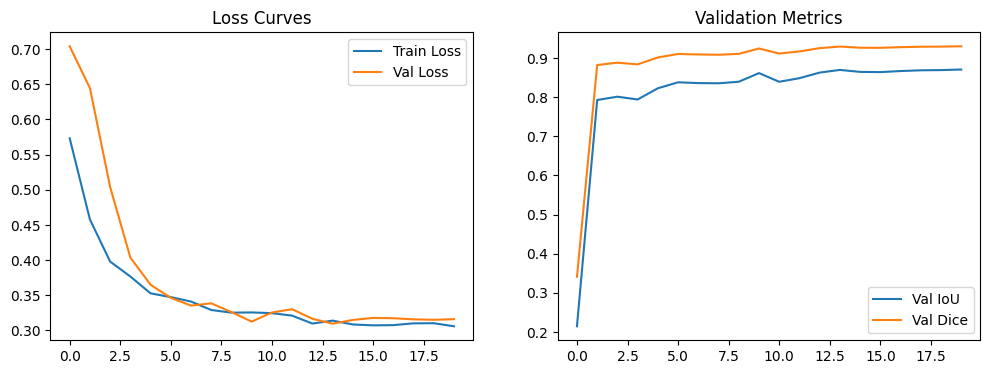

In [9]:
# Plot Training Progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_iou'], label='Val IoU')
plt.plot(history['val_dice'], label='Val Dice')
plt.title('Validation Metrics')
plt.legend()
plt.show()

## 8. Inference & Visualization
We load the best saved model and visualize the results on the validation set.

**Visualization Details:**
* **RGB Composite:** We extract indices 2 (Red), 1 (Green), and 0 (Blue) to create a True Color image.
* **Heatmap:** The raw sigmoid probability map.
* **Boundary Overlay:** We detect edges on the binary mask and overlay them on the original image.

Loaded best model weights.


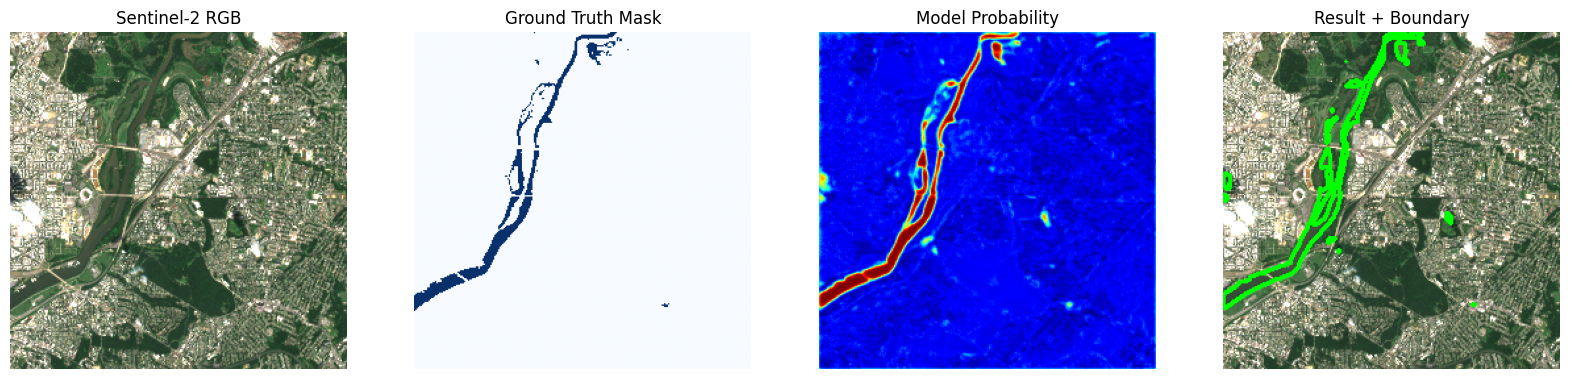

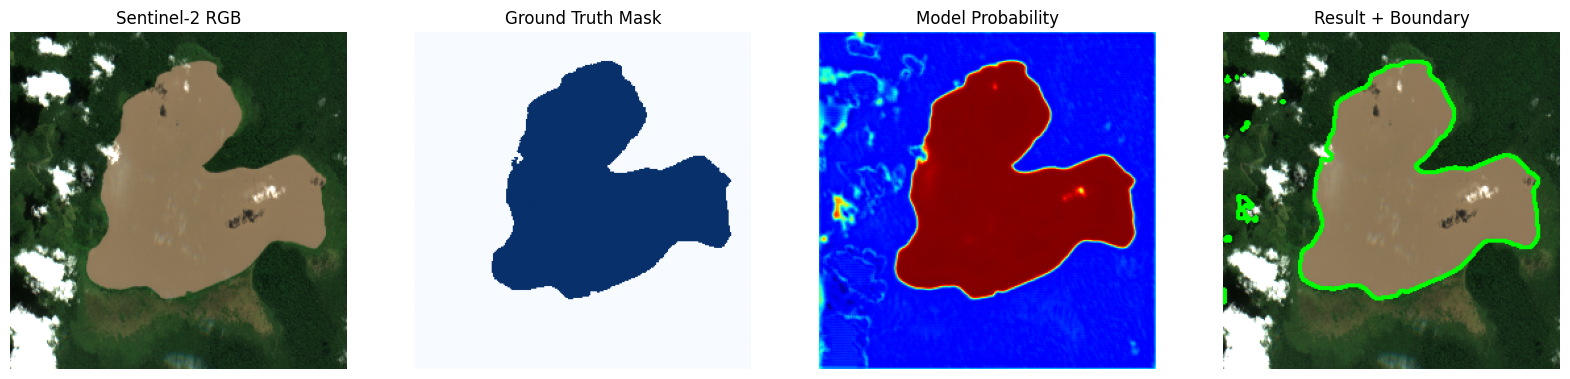

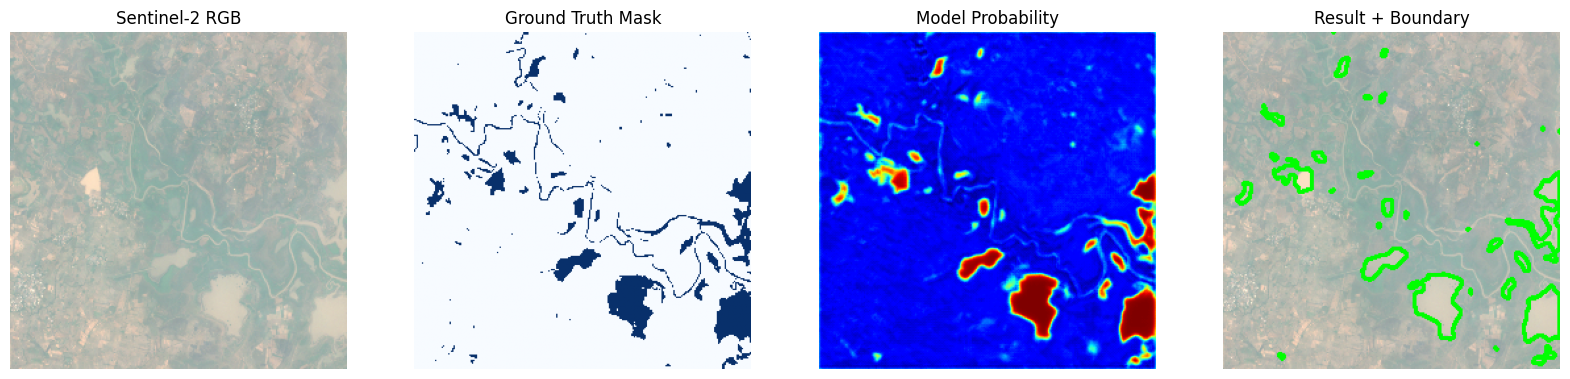

In [10]:
def visualize_results(model, dataset, num_samples=3):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    for idx in indices:
        image, mask = dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            logit = model(input_tensor)
            prob = torch.sigmoid(logit)
            pred_mask = (prob > 0.5).float()

        # Prepare for plotting
        # Image: (C, H, W) -> (H, W, C)
        img_np = image.cpu().numpy().transpose(1, 2, 0)

        # Extract RGB (Red=2, Green=1, Blue=0)
        # Note: Depending on normalization, we might need to brighten it for display
        rgb_img = img_np[:, :, [2, 1, 0]]
        # Simple brightness boost for visualization if too dark
        rgb_img = np.clip(rgb_img * 1.5, 0, 1)

        mask_np = mask.squeeze().numpy()
        pred_np = pred_mask.cpu().squeeze().numpy()
        prob_np = prob.cpu().squeeze().numpy()

        # Create Overlay with Contours
        contour_overlay = rgb_img.copy()
        # Resize pred for contour finding if necessary (opencv handles numpy)
        pred_uint8 = (pred_np * 255).astype(np.uint8)
        contours, _ = cv2.findContours(pred_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(contour_overlay, contours, -1, (0, 1, 0), 2) # Green contours

        # Plot
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))

        axs[0].imshow(rgb_img)
        axs[0].set_title("Sentinel-2 RGB")
        axs[0].axis('off')

        axs[1].imshow(mask_np, cmap='Blues')
        axs[1].set_title("Ground Truth Mask")
        axs[1].axis('off')

        axs[2].imshow(prob_np, cmap='jet')
        axs[2].set_title("Model Probability")
        axs[2].axis('off')

        axs[3].imshow(contour_overlay)
        axs[3].set_title("Result + Boundary")
        axs[3].axis('off')

        plt.show()

# Load best weights
if os.path.exists(Config.SAVE_PATH):
    model.load_state_dict(torch.load(Config.SAVE_PATH))
    print("Loaded best model weights.")
    visualize_results(model, val_dataset)
else:
    print("No model saved yet.")

## 9. Conclusion & Next Steps

We have successfully trained a TransUNet model on 6-band Sentinel-2 imagery.

**Possible Improvements:**
1.  **Test Time Augmentation (TTA):** Average predictions from flipped/rotated versions of the validation image.
2.  **Advanced Post-Processing:** Use Conditional Random Fields (CRF) to sharpen boundaries.
3.  **Spectral Indices:** Add NDWI (Normalized Difference Water Index) as a 7th input channel to give the model a "hint" about water location.
4.  **Full Swin-Transformer:** Replace the CNN encoder entirely with a Swin Transformer backbone (requires installing `timm` or `mmsegmentation`).